In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
# Dataset

path = "E:/Research/Ovarian Cancer/Articles/Orginal/"
data = pd.read_excel(path+"data_ready.xlsx")

df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,Age,Grading,Histology,Type,Status,MonthSurvive,YearSurvive
1,17.0,9.0,Undifferentiated,type_2,1.0,1,1
2,55.0,9.0,Serous carcinoma,type_2,1.0,0,1
3,68.0,9.0,Non-specific,Non-specific,1.0,0,1
4,66.0,9.0,Clear cell carcinoma,type_1,1.0,0,1
5,72.0,9.0,Serous carcinoma,type_2,1.0,0,1


In [5]:
# Feature transformers

cols_standardize = ['Age']
cols_onehotencoded = ['Grading', 'Histology', 'Type']

standardize = [([col], StandardScaler()) for col in cols_standardize]
onehot_encoded = [([col], OneHotEncoder(handle_unknown='ignore')) for col in cols_onehotencoded]

#encoded = [([col], LabelEncoder()) for col in cols_labelencoded]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + onehot_encoded)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
get_target = lambda df: (df['MonthSurvive'].values, df['Status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [8]:
# Neural Net

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [9]:
# training the mode

model = CoxPH(net, tt.optim.Adam)

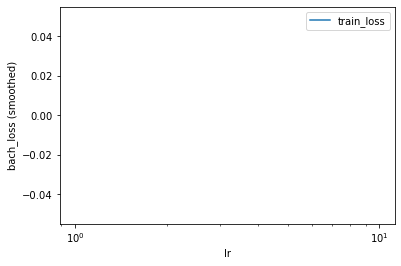

In [10]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [11]:
lrfinder.get_best_lr()

0.0001

In [12]:
model.optimizer.set_lr(0.001)

In [13]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [14]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	
9:	[0s / 0s],	
Wall time: 381 ms


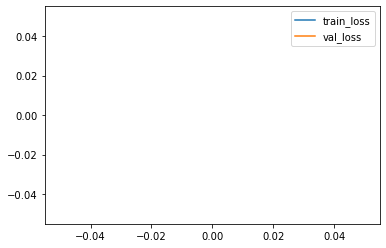

In [15]:
_ = log.plot()

In [16]:
model.partial_log_likelihood(*val).mean()

-5.673918724060059

In [17]:
# prediction

_ = model.compute_baseline_hazards()

In [18]:
surv = model.predict_surv_df(x_test)

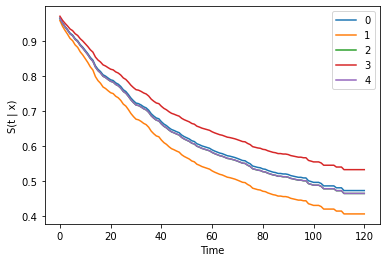

In [19]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
# evaluation

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [21]:
ev.concordance_td()

0.5091108302494113

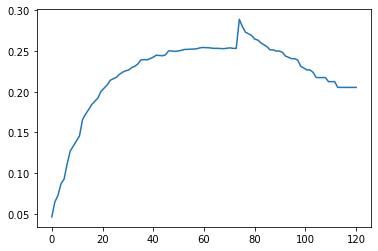

In [22]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [23]:
ev.integrated_brier_score(time_grid)

0.2225817836302286

In [ ]:
ev.integrated_nbll(time_grid)